# Imports and dataset loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.multioutput import MultiOutputRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasRegressor
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
import autokeras as ak
import tensorflow as tf
import pandas as pd

maxAmpNumber = 7

gainArray     = []
lossArray     = []

originalDataset1 = []
binaryDataset1   = []

originalDataset2 = []
binaryDataset2   = []

for i in range(2, maxAmpNumber + 1):
    originalDataset1 = pd.read_csv('d1/{}amp/dataset-{}.txt'.format(i, i), sep = ',', header = None)
    originalDataset2 = pd.read_csv('d2/{}amp/dataset-{}.txt'.format(i, i), sep = ',', header = None)
    
    binaryDataset1.append([])
    binaryDataset2.append([])
    
    for line in originalDataset1.values:
        myList = [1 if j != 0 else 0 for j in line[:40]]
        myList.extend(line[40:])
        binaryDataset1[-1].append(myList)

    binaryDataset1[-1] = pd.DataFrame(binaryDataset1[-1])
    
    for line in originalDataset2.values:
        myList = [1 if j != 0 else 0 for j in line[:40]]
        myList.extend(line[40:])
        binaryDataset2[-1].append(myList)
        
    binaryDataset2[-1] = pd.DataFrame(binaryDataset2[-1])

'''
ampNumber -> [2, 3, 4, 5, 6, 7]
datasetIndex -> [0, 1] (full and optimized dataset)
'''
def loadDataset(ampIndex, datasetIndex): 
    ampIndex -= 2
    
    binaryDataset = binaryDataset1 if datasetIndex == 0 else binaryDataset2
    dataset       = binaryDataset[ampIndex].values[:, :40]
    
    for i in range(0, ampNumber * 2, 2):
        gain    = np.array(binaryDataset[ampIndex].values[:, 40 + i])
        #gain    = gainScaler.transform(gain.reshape(-1, 1))
        gain    = gain.reshape(-1, 1)
        dataset = np.hstack((dataset, gain))
        
        loss    = np.array(binaryDataset[ampIndex].values[:, 40 + i + 1])
        #loss    = lossScaler.transform(loss.reshape(-1, 1))
        loss    = loss.reshape(-1, 1)
        dataset = np.hstack((dataset, loss))
                
    X, y = np.array(dataset[:, :40]), np.array(dataset[:, 40:])
    return X, y
    
def getGainError(value1, value2):
    return (value1 - value2)**2

def getLossError(value1, value2):
    return (value1 - value2)**2

/home/leandro/Documentos/Mestrado/ACOPResults/acopEnv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Model setup

In [2]:
def initModels(ampNumber):
    models = []
    
    for i in range(ampNumber):
        #models.append(MultiOutputRegressor(KNeighborsRegressor()))
        models.append(BaggingRegressor(n_estimators = 10, random_state = 0))
    
    return models

# Cross validation function

In [3]:
def crossValidate(regressor, X, y, folds = 5):
    foldSize   = int(math.ceil(X.shape[0] / folds))
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(X, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(y, np.s_[sliceBegin: sliceEnd], 0)
        
        regressor.fit(X_train, y_train)
            
        X_test = X[sliceBegin: sliceEnd]
        y_test = y[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            gainError += getGainError(predicted[0], expected[0]) 
            lossError += getLossError(predicted[1], expected[1])
                 
        gainErrors.append(gainError / foldSize)
        lossErrors.append(lossError / foldSize)
        
    return np.sqrt(np.array(gainErrors)), np.sqrt(np.array(lossErrors))

In [4]:
def trainModel(ampNumber, datasetIndex, models):  
    gainRMSE, gainSTD, lossRMSE, lossSTD = [], [], [], []
    
    for i in range(ampNumber):
        X, y = loadDataset(ampNumber, datasetIndex)
        
        gainErrors, lossErrors = crossValidate(models[i], X, y[:, i * 2: i * 2 + 2])

        gainRMSE.append(np.mean(gainErrors))
        gainSTD.append(np.std(gainErrors))
        lossRMSE.append(np.mean(lossErrors))
        lossSTD.append(np.std(lossErrors))
    
    print(gainRMSE, "=> %0.2f (+/- %0.2f)" % (np.mean(gainRMSE), np.std(gainRMSE)))
    print(lossRMSE, "=> %0.2f (+/- %0.2f)\n" % (np.mean(lossRMSE), np.std(lossRMSE)))
        
    return [gainRMSE, gainSTD, lossRMSE, lossSTD]

# Plotting functions

In [5]:
def plotErrorbar(data, ampNumber):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    x = [i + 1 for i in range(ampNumber)]
    
    ax1.errorbar(x, data[0][0], data[0][1], marker = 'x', ls = 'none', capsize = 10, label = 'Full dataset')
    ax1.errorbar(x, data[1][0], data[1][1], marker = 'P', ls = 'none', capsize = 10, label = 'Optimized dataset')
    ax1.set(xlabel='Amplifier', ylabel='RMSE')
    ax1.set_title('Gain error for ' + str(ampNumber) + ' amplifiers')
    ax1.set_xticks(x)
    
    ax2.errorbar(x, data[0][2], data[0][3], marker = 'x', ls = 'none', capsize = 10, label = 'Full dataset')
    ax2.errorbar(x, data[1][2], data[1][3], marker = 'P', ls = 'none', capsize = 10, label = 'Optimized dataset')
    ax2.set(xlabel='Amplifier', ylabel='RMSE')
    ax2.set_title('Loss error for ' + str(ampNumber) + ' amplifiers')
    ax2.set_xticks(x)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys())
    
    fig.savefig("graphs/graph-{}amps".format(ampNumber))

# Putting all together

#2 amps. Full dataset
[3.5260660903398104, 2.5644528838219687] => 3.05 (+/- 0.48)
[3.7359244537121796, 1.6617956132683698] => 2.70 (+/- 1.04)

#2 amps. Optimized dataset
[0.90242977725439, 1.515478299091939] => 1.21 (+/- 0.31)
[3.785954250537535, 1.5883889147063823] => 2.69 (+/- 1.10)

#3 amps. Full dataset
[3.100004860295431, 3.7399120305546893, 0.7994042950454608] => 2.55 (+/- 1.26)
[3.7754087369203306, 3.7867895011086032, 0.3154125429631782] => 2.63 (+/- 1.63)

#3 amps. Optimized dataset
[1.1015623758770468, 4.105437108591518, 1.0476757989277434] => 2.08 (+/- 1.43)
[3.7380959348898353, 3.4335130673597063, 0.23817473631794828] => 2.47 (+/- 1.58)

#4 amps. Full dataset
[3.0800660736337426, 3.0046909959356034, 1.4330570465696524, 3.1235941847949173] => 2.66 (+/- 0.71)
[3.8378581592036753, 3.353261648800278, 3.8282409674495987, 2.2396181603161245] => 3.31 (+/- 0.65)

#4 amps. Optimized dataset
[2.8607606838473676, 3.8082264112778335, 1.3164993828365081, 3.2998891846852003] => 2.82 (+/- 

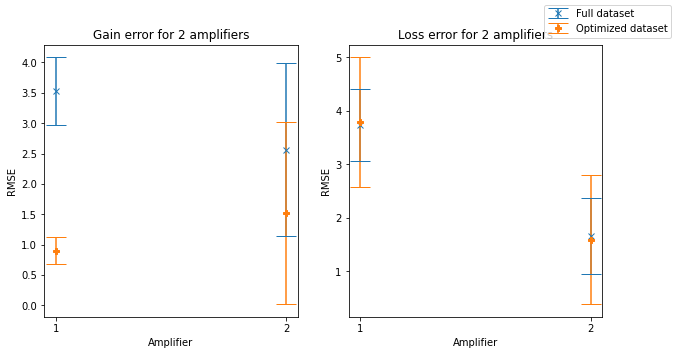

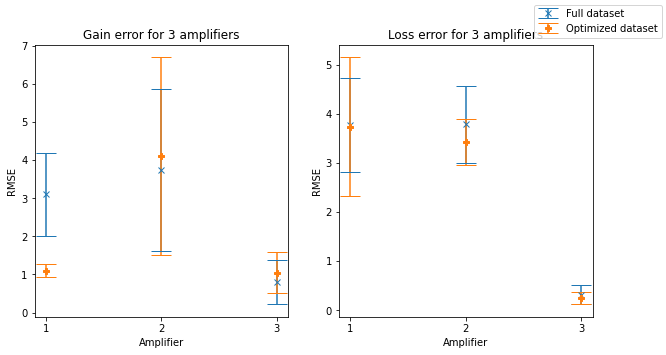

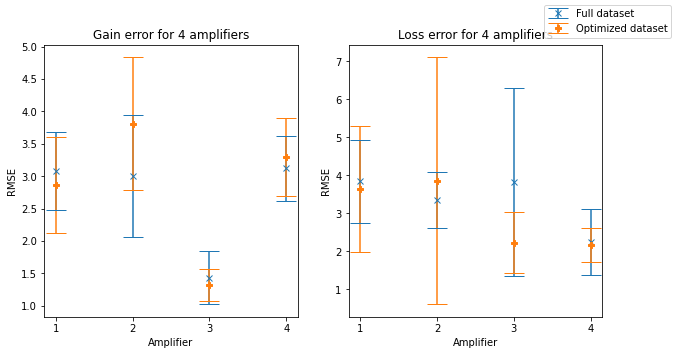

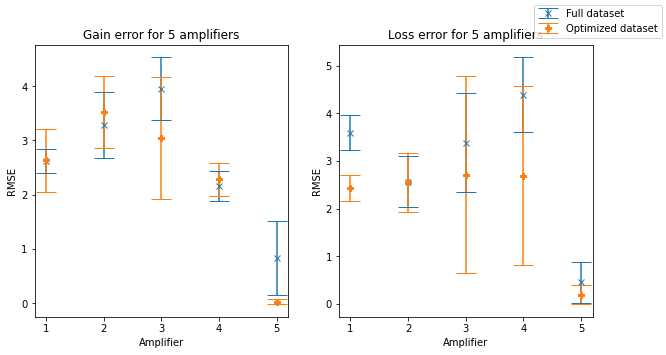

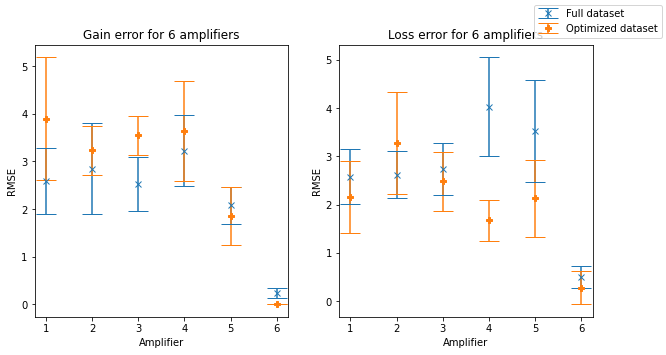

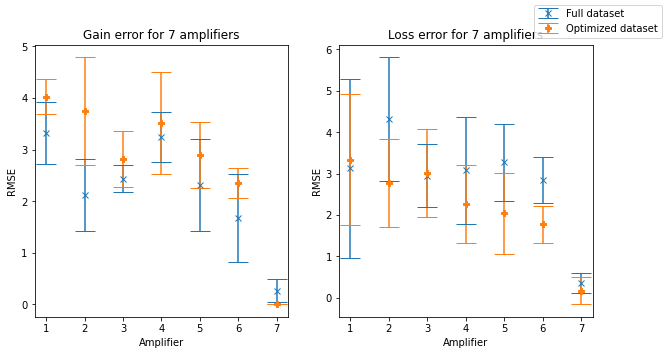

In [6]:
for ampNumber in range(2, maxAmpNumber + 1):
    data = []
    
    for datasetIndex in range(2):
        print("#{} amps. {} dataset".format(ampNumber, "Full" if datasetIndex == 0 else "Optimized"))
        gainArray = []
        lossArray = []
    
        models = initModels(i)
        data.append(trainModel(ampNumber, datasetIndex, models))
    
    plotErrorbar(data, ampNumber)